In [1]:
# d = distances between items
# w = items' weights
# n = number of items
# M = max load
# K = number of qRobots

d = [[0 , 16, 30, 20, 40, 23],   
    [16, 0 , 12, 8 , 7 , 22],
    [30, 12, 0 , 10, 23, 40],
    [20, 8 , 10, 0 , 11, 18],
    [40, 7 , 23, 11, 0 , 16],
    [23, 22, 40, 18, 16, 0]]

w = [0, 8, 8, 3, 3, 1] 
n = len(d) - 1 
M = 16
K = 2

In [2]:
from docplex.mp.model import Model

# creating the model

mdl = Model('qRobot')
x = {(t,i,p): mdl.binary_var(name='x_{0}_{1}_{2}'.format(t,i,p)) 
     for t in range(n+2) for i in range(n+1) for p in range(K)}

# Our Objective Function
qRobot_Objective_Function = mdl.sum(x[(t-1,i,p)]* x[(t,j,p)]*d[i][j] 
                                    for p in range(K) for t in range(1,n+2) for i in range(n+1)for j in range(n+1))
#Minimize our Objective funtion. 
mdl.minimize(qRobot_Objective_Function)


# constraints



#All the qRobots start from Depot

mdl.add_constraint(mdl.sum(x[0,0, p] for p in range(K)) == K)


#All the qRobots finish at Depot

mdl.add_constraint(mdl.sum(x[n+1,0, p] for p in range(K)) == K)


#For every robot p, there is more than one of the weights of nodes
# through which it passes and it is remembered that M

for p in range(K):
    mdl.add_constraint(mdl.sum(x[(t,i,p)] * w[i] for i in range(1,n+1) for t in range(1,n+2)) <= M)

    
#Each robot can only be one node at any time

for t in range(n+2):
    for p in range(K):
        mdl.add_constraint(mdl.sum(x[(t,i,p)] for i in range(n+1)) == 1)

#Throughout the entire route, the robots together pass each node only once.

for i in range(1,n+1):
    mdl.add_constraint(mdl.sum(x[(t,i,p)] for p in range(K) for t in range(1,n+2)) == 1)


In [3]:
dir(mdl)

['DEFAULT_OBJECTIVE_FMT',
 'DEFAULT_VAR_VALUE_QUOTED_SOLUTION_FMT',
 'DEFAULT_VAR_VALUE_UNQUOTED_SOLUTION_FMT',
 '_Model__allpwlfuncs',
 '_Model__engine',
 '_Model__notify_new_model_object',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_batch_logical_cts',
 '_add_constraint_internal',
 '_add_indicator',
 '_add_progress_listener',
 '_add_pwl_constraint_internal',
 '_add_pwl_expr',
 '_add_qprogress_listener',
 '_add_sos',
 '_add_var_container',
 '_aggregator',
 '_all_containers',
 '_allkpis',
 '_apply_parameters_to_engine',
 '_benders_annotations',
 '_binary_vartype',
 '_can_solve',
 '_change_var_types_internal',
 '_check_b

In [4]:
{ (a,b) : coef for a,b,coef in mdl.objective_expr.iter_quad_triplets() }

{(docplex.mp.Var(type=B,name='x_0_0_0'),
  docplex.mp.Var(type=B,name='x_1_1_0')): 16,
 (docplex.mp.Var(type=B,name='x_0_0_0'),
  docplex.mp.Var(type=B,name='x_1_2_0')): 30,
 (docplex.mp.Var(type=B,name='x_0_0_0'),
  docplex.mp.Var(type=B,name='x_1_3_0')): 20,
 (docplex.mp.Var(type=B,name='x_0_0_0'),
  docplex.mp.Var(type=B,name='x_1_4_0')): 40,
 (docplex.mp.Var(type=B,name='x_0_0_0'),
  docplex.mp.Var(type=B,name='x_1_5_0')): 23,
 (docplex.mp.Var(type=B,name='x_0_1_0'),
  docplex.mp.Var(type=B,name='x_1_0_0')): 16,
 (docplex.mp.Var(type=B,name='x_0_1_0'),
  docplex.mp.Var(type=B,name='x_1_2_0')): 12,
 (docplex.mp.Var(type=B,name='x_0_1_0'),
  docplex.mp.Var(type=B,name='x_1_3_0')): 8,
 (docplex.mp.Var(type=B,name='x_0_1_0'),
  docplex.mp.Var(type=B,name='x_1_4_0')): 7,
 (docplex.mp.Var(type=B,name='x_0_1_0'),
  docplex.mp.Var(type=B,name='x_1_5_0')): 22,
 (docplex.mp.Var(type=B,name='x_0_2_0'),
  docplex.mp.Var(type=B,name='x_1_0_0')): 30,
 (docplex.mp.Var(type=B,name='x_0_2_0'),
  do

In [5]:
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import InequalityToEquality, QuadraticProgramToQubo

# duplex model to qubo

qp = QuadraticProgram()
qp.from_docplex(mdl)
    
conv = InequalityToEquality()
eq_model = conv.convert(qp)
    
conv2 = QuadraticProgramToQubo()
qubo_model = conv2.convert(eq_model)
    

In [6]:
import pennylane as qml

# qubo to ising

op, offset = qubo_model.to_ising()
coeffs = []
obs = []
for opt in op:
        coeffs.append(opt.coeff)
        string = opt.primitive.to_label()
        if string.count("Z") == 1:
            obs.append(qml.PauliZ(wires = string.index("Z")))
        elif string.count("Z") == 2:
            first = string.index("Z")
            string2 = "I" * (first + 1) + string[first+1:]
            second = string2.index("Z")
            obs.append(qml.PauliZ(wires = first) @ qml.PauliZ(wires = second))
            
hamiltonian = qml.Hamiltonian(coeffs, obs)

# so with "hamiltonian" we can solve the problem using VQE or QAOA from pennylane 

In [7]:
# Now let's prepare this hamiltonian in the DWave-qubo format

dic_ising = {}
for coef, obs in zip(*hamiltonian.terms):
    wires_position = obs.wires.toarray()
    if len(wires_position) == 1:
        dic_ising[(wires_position[0], wires_position[0])] = coef
    elif len(wires_position) == 2:
        dic_ising[(wires_position[0], wires_position[1])] = coef

dic_qubo = {}
for w1, w2 in dic_ising:
    if not (w1,w1) in dic_qubo:
        dic_qubo[(w1,w1)] = 0
    if not (w2,w2) in dic_qubo:
        dic_qubo[(w2,w2)] = 0
    if not (w1,w2) in dic_qubo:
        dic_qubo[(w1,w2)] = 0
    if w1 == w2:
        dic_qubo[(w1,w2)] -= 2* dic_ising[(w1,w2)]
    else:
        dic_qubo[(w1,w1)] -= 2* dic_ising[(w1,w2)]
        dic_qubo[(w2,w2)] -= 2* dic_ising[(w1,w2)]
        dic_qubo[(w1,w2)] += 4* dic_ising[(w1,w2)]
        
# dic_qubo is the dictionary that Dwave admit

In [8]:
!pip3 install dwave-ocean-sdk

     |████████████████████████████████| 137 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 225 kB 19.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 660 kB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 12.2 MB/s ta 0:00:01
     |████████████████████████████████| 4.6 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 878 kB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 215 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 395 kB 16.4 MB/s eta 0:00:01
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
     |████████████████████████████████| 226 kB 20.5 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 13.4 MB/s eta 0:00:01
  Using cached numpy-1.24.4-cp38-cp38-macosx_

     |████████████████████████████████| 17.6 MB 958 kB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: dimod
    Found existing installation: dimod 0.10.10
    Uninstalling dimod-0.10.10:
      Successfully uninstalled dimod-0.10.10
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.8.2
    Uninstalling pydantic-1.8.2:
      Successfully uninstalled pydantic-1.8.2
  Attempting uninstall: dwave-networkx
    Found existing installation: dwave-networkx 0.8.10
    Unin

In [9]:
from neal import SimulatedAnnealingSampler

# Now we run the problem in DWave 
# Here we use the simulator but you can use the real device if you have got access

shots = 10000
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(dic_qubo,num_reads = shots)

In [10]:
# Finally we translate the qubo solution to the problem domain

m = shots 
m_paths = []
for indx, sol in enumerate(sampleset.samples(m)):
    sols = []
    aux = 0
    paths = []
    for k in range(K):
        paths.append([])
    for t in range(n+2):
        for i in range(n+1):
            for k in range(K):
                if sol[len(sol)-1-aux] == 1:
                    paths[k].append(i)
                aux += 1
    show = True
    reps = [0]*(n+1)
    for i in range(K):
        
        if len(paths[i]) != 0:
            if paths[i][-1] != 0 or paths[i][0] != 0:
                show = False
        if len(paths[i]) != n+2:
            show = False
        
        for j in paths[i]:
            if j != 0:
                reps[j] += 1
    
    for k in reps:
        if k != 1 and k != 0:
            show = False
            
    if show:
        for i in range(K):
            sols.append(paths[i])
    if sols != []:
        m_paths.append(sols)

[(0, 3), (3, 2), (2, 0)]
[(0, 5), (5, 4), (4, 1), (1, 0)]


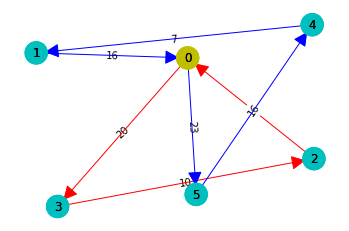

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# m_pahts contain different valid solutions, let's print the first of all

G = nx.from_numpy_matrix(np.array(d))
G = nx.DiGraph(G)

def print_solution(paths):
    colors = ["r","b","y", "g","c","v","cb"]
    pos = nx.spring_layout(G)
    for indx, path in enumerate(paths):
        aux = []
        for i in path:
            if i != 0:
                aux.append(i)
        aux.append(0)
        aux.insert(0,0)

        edges = []

        for i in range(len(aux)):
            if aux[i] != aux[(i+1) % len(aux)]:
                edges.append((aux[i], aux[(i+1) % len(aux)]))

        # show solution
        plt.axis('off');
        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                               node_color = ["y"] + ["c"] *n, node_size = 500)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = {l:(d[l[0]][l[1]]) for l in edges})
        print(edges)
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[indx], arrows = True, arrowsize=30)
    plt.plot()
    
print_solution(m_paths[0])
# lengths not to scale